# vanishing gradient
这里我们在简单的包含两层隐藏层的神经网络中展示使用非线性的`sigmoid`和`ReLU`函数的差异。

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
# 生成随机数据 -- 非线性可分
np.random.seed(0)
N = 100
D = 2
K = 4
X = np.zeros((N*K, D))

In [3]:
num_train_examples = X.shape[0]

In [4]:
y = np.zeros(N*K, dtype='uint8')

In [5]:
for j in xrange(K):
    ix = range(N*j, N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j

In [6]:
fig = plt.figure()

(-1, 1)

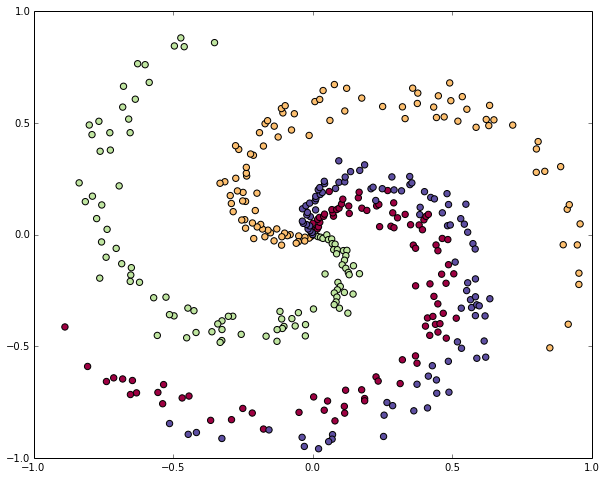

In [9]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim([-1,1])
plt.ylim([-1,1])

The sigmoid function "squashes" inputs to lie between 0 and 1. Unfortunately, this means that for inputs with sigmoid output close to 0 or 1, the gradient with respect to those inputs are close to zero. This leads to the phenomenon of vanishing gradients, where gradients drop close to zero, and the net does not learn well.
On the other hand, the relu function (max(0, x)) does not saturate with input size. Plot these functions to gain intution.
sigmoid 函数将输入转化为0到1之间的数。不幸的是，这意味着对于那些接近0或者1的输入，这些输入的梯度将接近0。这就导致消失的梯度的现象出现。当梯度掉到0的附近的时候，这个网络的学习效果就不好了。

In [10]:
def sigmoid(x):
    x = 1 / (1+np.exp(-x))
    return x

def sigmoid_grad(x):
    return (x) * (1 - x)

def relu(x):
    return np.maximum(0, x)

下面我们尝试建立一个简单的三层神经网络（两层隐藏层），并可以切换`ReLU/sigmoid`

In [14]:
def three_layer_net(NONLINEARITY,X,y, model, step_size, reg):
    h = model['h']
    h2 = model['h2']
    W1= model['W1']
    W2= model['W2']
    W3= model['W3']
    b1= model['b1']
    b2= model['b2']
    b3= model['b3']
    
    # gradient descent loop
    num_examples = X.shape[0]
    plot_array_1 = []
    plot_array_2 = []
    for i in xrange(50000):
        if NONLINEARITY=='RELU':
            hidden_layer = relu(np.dot(X, W1) + b1)
            hidden_layer2 = relu(np.dot(hidden_layer, W2) +b2)
            scores = np.dot(hidden_layer2, W3) + b3
        elif NONLINEARITY== 'SIGM':
            hidden_layer = sigmoid(np.dot(X, W1) + b1)
            hidden_layer2 = sigmoid(np.dot(hidden_layer, W2) + b2)
            scores = np.dot(hidden_layer2, W3) + b3
        
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        # average cross-entropy loss and regularization
        correct_logprobs = -np.log(probs[range(num_examples), y])
        data_loss = np.sum(correct_logprobs)/num_examples
        reg_loss = 0.5*reg*np.sum(W1*W1) + 0.5*reg*np.sum(W2*W2) + 0.5*reg*np.sum(W3*W3)
        loss = data_loss + reg_loss
        if i % 1000 == 0:
            print "iteration %d: loss %f" % (i, loss)
            
        # gradient on scores
        dscores = probs
        dscores[range(num_examples),y] -= 1
        dscores /= num_examples
        
        # BP
        dW3 = (hidden_layer2.T).dot(dscores)
        db3 = np.sum(dscores, axis=0, keepdims=True)
        
        if NONLINEARITY == 'RELU':
            dhidden2 = np.dot(dscores, W3.T)
            dhidden2[hidden_layer2 <= 0] = 0
            dW2 = np.dot(hidden_layer.T, dhidden2)
            plot_array_2.append(np.sum(np.abs(dW2))/np.sum(np.abs(dW2.shape)))
            db2 = np.sum(dhidden2, axis=0)
            dhidden = np.dot(dhidden2, W2.T)
            dhidden[hidden_layer <= 0] = 0
        
        elif NONLINEARITY=='SIGM':
            dhidden2 = dscores.dot(W3.T)*sigmoid_grad(hidden_layer2)
            dW2 = (hidden_layer.T).dot(dhidden2)
            plot_array_2.append(np.sum(np.abs(dW2))/np.sum(np.abs(dW2.shape)))
            db2 = np.sum(dhidden2, axis=0)
            dhidden = dhidden2.dot(W2.T)*sigmoid_grad(hidden_layer)
        
        dW1 = np.dot(X.T, dhidden)
        plot_array_1.append(np.sum(np.abs(dW1))/np.sum(np.abs(dW1.shape)))
        db1 = np.sum(dhidden, axis=0)
        
        # add regularization
        dW3 += reg*W3
        dW2 += reg*W2
        dW1 += reg*W1
        
        grads={}
        grads['W1'] = dW1
        grads['W2'] = dW2
        grads['W3']=dW3
        grads['b1']=db1
        grads['b2']=db2
        grads['b3']=db3
        
        W1 += -step_size * dW1
        b1 += -step_size * db1
        W2 += -step_size * dW2
        b2 += -step_size * db2
        W3 += -step_size * dW3
        b3 += -step_size * db3
        
    if NONLINEARITY=='RELU':
        hidden_layer = relu(np.dot(X, W1) + b1)
        hidden_layer2 = relu(np.dot(hidden_layer, W2) + b2)
    elif NONLINEARITY=='SIGM':
        hidden_layer = sigmoid(np.dot(X, W1) + b1)
        hidden_layer2 = sigmoid(np.dot(hidden_layer, W2) + b2)
    scores = np.dot(hidden_layer2, W3) + b3
    predicted_class = np.argmax(scores, axis=1)
    print "training accuracy: %.3f" % (np.mean(predicted_class == y))
    
    return plot_array_1, plot_array_2, W1, W2, W3, b1, b2, b3

使用`sigmoid`进行训练

In [12]:
N = 100
D = 2
K = 4
h = 50
h2 = 50
num_train_examples = X.shape[0]

model = {}
model['h'] = h # size of hidden layer 1
model['h2']= h2# size of hidden layer 2
model['W1']= 0.1 * np.random.randn(D,h)
model['b1'] = np.zeros((1,h))
model['W2'] = 0.1 * np.random.randn(h,h2)
model['b2']= np.zeros((1,h2))
model['W3'] = 0.1 * np.random.randn(h2,K)
model['b3'] = np.zeros((1,K))

(sigm_array_1, sigm_array_2, s_W1, s_W2,s_W3, s_b1, s_b2,s_b3) = three_layer_net('SIGM', X,y,model, step_size=1e-1, reg=1e-3)

iteration 0: loss 1.438011
iteration 1000: loss 1.389977
iteration 2000: loss 1.345859
iteration 3000: loss 1.153694
iteration 4000: loss 1.128080
iteration 5000: loss 1.123633
iteration 6000: loss 1.119967
iteration 7000: loss 1.116650
iteration 8000: loss 1.113578
iteration 9000: loss 1.110542
iteration 10000: loss 1.106746
iteration 11000: loss 1.099229
iteration 12000: loss 1.080281
iteration 13000: loss 1.046513
iteration 14000: loss 1.014531
iteration 15000: loss 0.993744
iteration 16000: loss 0.980771
iteration 17000: loss 0.972042
iteration 18000: loss 0.965758
iteration 19000: loss 0.960917
iteration 20000: loss 0.956857
iteration 21000: loss 0.953104
iteration 22000: loss 0.949267
iteration 23000: loss 0.944938
iteration 24000: loss 0.939557
iteration 25000: loss 0.932154
iteration 26000: loss 0.920883
iteration 27000: loss 0.902881
iteration 28000: loss 0.875825
iteration 29000: loss 0.844676
iteration 30000: loss 0.818416
iteration 31000: loss 0.799473
iteration 32000: loss

In [15]:
model={}
model['h'] = h # size of hidden layer 1
model['h2']= h2# size of hidden layer 2
model['W1']= 0.1 * np.random.randn(D,h)
model['b1'] = np.zeros((1,h))
model['W2'] = 0.1 * np.random.randn(h,h2)
model['b2']= np.zeros((1,h2))
model['W3'] = 0.1 * np.random.randn(h2,K)
model['b3'] = np.zeros((1,K))

(relu_array_1, relu_array_2, r_W1, r_W2,r_W3, r_b1, r_b2,r_b3) = three_layer_net('RELU', X,y,model, step_size=1e-1, reg=1e-3)

iteration 0: loss 1.402205
iteration 1000: loss 0.684200
iteration 2000: loss 0.324857
iteration 3000: loss 0.287615
iteration 4000: loss 0.269717
iteration 5000: loss 0.278321
iteration 6000: loss 0.262092
iteration 7000: loss 0.245400
iteration 8000: loss 0.248956
iteration 9000: loss 0.244913
iteration 10000: loss 0.240529
iteration 11000: loss 0.239424
iteration 12000: loss 0.243977
iteration 13000: loss 0.236470
iteration 14000: loss 0.239903
iteration 15000: loss 0.234705
iteration 16000: loss 0.234448
iteration 17000: loss 0.238777
iteration 18000: loss 0.237519
iteration 19000: loss 0.238741
iteration 20000: loss 0.231244
iteration 21000: loss 0.229329
iteration 22000: loss 0.234638
iteration 23000: loss 0.233089
iteration 24000: loss 0.233828
iteration 25000: loss 0.232262
iteration 26000: loss 0.234057
iteration 27000: loss 0.231537
iteration 28000: loss 0.231264
iteration 29000: loss 0.227374
iteration 30000: loss 0.230192
iteration 31000: loss 0.231657
iteration 32000: loss

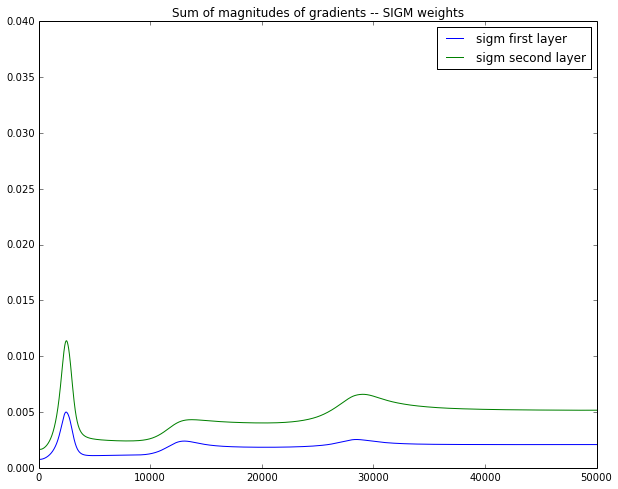

In [16]:
plt.plot(np.array(sigm_array_1))
plt.plot(np.array(sigm_array_2))
plt.title('Sum of magnitudes of gradients -- SIGM weights')
plt.legend(("sigm first layer", "sigm second layer"))

(0, 0.2)

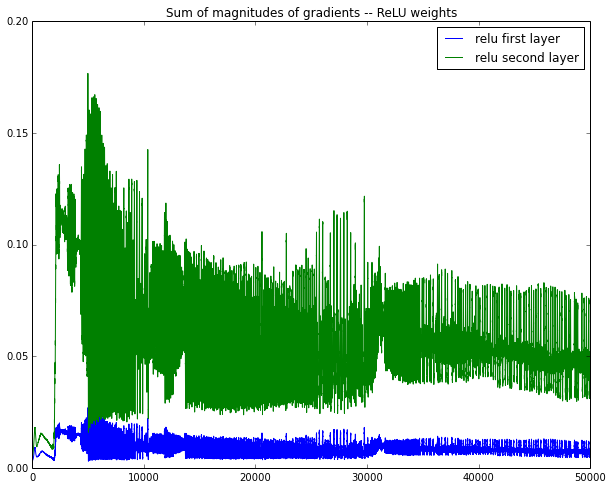

In [23]:
plt.plot(np.array(relu_array_1))
plt.plot(np.array(relu_array_2))
plt.title('Sum of magnitudes of gradients -- ReLU weights')
plt.legend(("relu first layer", "relu second layer"))
plt.ylim([0,0.2])

(-1.9593663176366283, 1.8806336823633751)

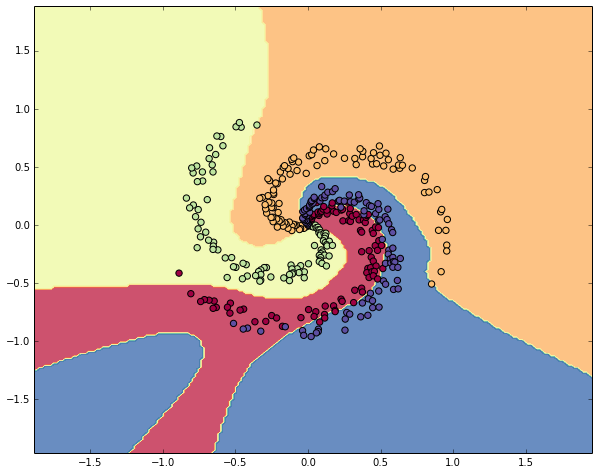

In [24]:
# plot the classifiers- SIGMOID
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(sigmoid(np.dot(sigmoid(np.dot(np.c_[xx.ravel(), yy.ravel()], s_W1) + s_b1), s_W2) + s_b2), s_W3) + s_b3
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

(-1.9593663176366283, 1.8806336823633751)

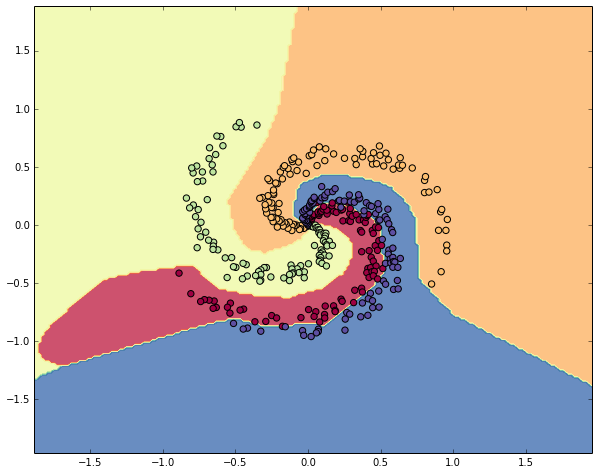

In [25]:
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(relu(np.dot(relu(np.dot(np.c_[xx.ravel(), yy.ravel()], r_W1) + r_b1), r_W2) + r_b2), r_W3) + r_b3
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())